In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import random


## Linear model and Optimizer

Defining the linear model and linear optimizer classes needed for the algorithm 1



In [2]:
import torch
import abc

from abc import ABC


# The linear model which implemented by pytorch
class TorchLinearModel(torch.nn.Module):
    def __init__(self, n):
        super(TorchLinearModel, self).__init__()
        self.linear = torch.nn.Linear(n, 1, bias=False)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred
    
    
# The abstract optimizer model which should have model, optimizer, and criterion
class Optimizer(ABC):
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    @abc.abstractmethod
    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        torch_old_weight = torch.from_numpy(np.array(old_weight, dtype=np.float32))
        self.model.linear.weight.data = torch_old_weight
        for iterinner in range(5):
            self.optimizer.zero_grad()
            y_pred = self.model(x_data)
            loss1 = self.criterion(y_pred, y_data)
            loss2 = 1 / (2 * regularizer_term) * torch.mean((self.model.linear.weight - torch_old_weight) ** 2) 
            loss = loss1 + loss2
            loss.backward()
            self.optimizer.step()

        return self.model.linear.weight.data.numpy()
    
    
# The Linear optimizer model which implemented by pytorch    
class TorchLinearOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLinearOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLinearOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)


## Create SBM

Creating the SBM with two clusters $|C_1| = |C_2| = 100$. Two nodes within the same cluster are connected by an edge with probability pin, Two nodes from different clusters are connected by an edge with probability pout.
Each node $i ∈ V$ represents a local dataset consisting of $m$ feature vectors $x^{(i,1)} , . . . , x^{(i,m)} \in R^n$ . The feature vectors are i.i.d. realizations of a standard Gaussian random vector $x ∼ N(0,I)$.
The labels $y^{(i)}_1,...,y^{(i)}_m \in R$ of the nodes $i \in V$ are generated according to the linear model $y^{(i)}_r = (x^{(i,r)})^T \bar{w}^{(i)} + \epsilon$, with $\epsilon ∼ N(0, \sigma)$, weight vector $w^{(i)} = (2, 2)^T$ for $i \in C_1$ and $w^{(i)} = (−2,2)^T$ for $i \in C_2$ .

In [3]:
from torch.autograd import Variable
from graspy.simulations import sbm


def get_sbm_2blocks_data(m=5, n=2, pin=0.5, pout=0.001, noise_sd=0):
    '''
    :param m, n: shape of features vector for each node
    :param pin: the probability of edges inside each cluster
    :param pout: the probability of edges between the clusters
    :param noise_sd: the standard deviation of the noise for calculating the labels
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    :return true_labels: a list containing the true labels of the nodes
    :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    '''
    N1, N2 = 100, 100

    # generate graph G which is a SBM wich 2 clusters
    G = sbm(n=[N1, N2], p=[[pin, pout],[pout, pin]])
    '''
    G: generated SBM graph with 2 clusters
    '''

    N = len(G)
    E = int(len(np.argwhere(G > 0))/2)
    '''
    N: total number of nodes
    E: total number of edges
    '''
    
    
    # create B(adjacency matrix) and edges's weights vector(weight_vec) based on the graph G
    B = np.zeros((E, N))
    '''
    B: adjacency matrix of the graph with the shape of E*N
    '''
    weight_vec = np.zeros(E)
    '''
    weight_vec: a list containing the edges's weights of the graph with the shape of E
    '''
    
    cnt = 0
    for i, j in np.argwhere(G > 0):
        if i > j:
            continue
        B[cnt, i] = 1
        B[cnt, j] = -1

        weight_vec[cnt] = 1
        cnt += 1
        
    
    # define weight vectors for each cluster of the graph
    
    W1 = np.array([2, 2])
    '''
    W1: the weigh vector for the first cluster
    '''
    W2 = np.array([-2, 2])
    '''
    W2: the weigh vector for the second cluster
    '''
    
    
    # create the data of each node needed for the algorithm 1 
    
    node_degrees = np.array((1.0 / (np.sum(abs(B), 0)))).ravel()
    '''
    node_degrees: a list containing the nodes degree for the alg1 (1/N_i)
    '''
    
    datapoints = {}
    '''
    datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1,
    which are features, label, degree, and also the optimizer model for each node
    '''
    true_labels = []
    '''
    true_labels: the true labels for the nodes of the graph
    '''
    for i in range(N):
        features = np.random.normal(loc=0.0, scale=1.0, size=(m, n))
        '''
        features: the feature vector of node i which are i.i.d. realizations of a standard Gaussian random vector x~N(0,I)
        '''
        
        if i < N1: # nodes in the first cluster
            label = np.dot(features, W1) + np.random.normal(0,noise_sd)
        else: # nodes in the second cluster
            label = np.dot(features, W2) + np.random.normal(0,noise_sd)
        '''
        label: the label of the node i that is generated according to the linear model y = x^T w + e
        '''
            
        true_labels.append(label)
            
        model = TorchLinearModel(n)
        '''
        model : the linear model for the node i that is implemented by pytorch
        '''
        optimizer = TorchLinearOptimizer(model)
        '''
        optimizer : the optimizer model for the node i that is implemented by pytorch with MSE loss function
        '''
            
        datapoints[i] = {
            'features': Variable(torch.from_numpy(features)).to(torch.float32),
            'degree': node_degrees[i],
            'label': Variable(torch.from_numpy(label)).to(torch.float32),
            'optimizer': optimizer
        }
        

    return B, weight_vec, np.array(true_labels), datapoints


## Penalty Function

Defining the penalty functions for the algorithm 1 which are norm1, norm2, or mocha



In [4]:
# The abstract penalty function which has a function update
class Penalty(ABC):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        self.lambda_lasso = lambda_lasso
        self.weight_vec = weight_vec
        self.Sigma = Sigma

    @abc.abstractmethod
    def update(self, new_u):
        pass


# The norm2 penalty function
class Norm2Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm2Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array(lambda_lasso * weight_vec)

    def update(self, new_u):
        normalized_u = np.where(np.linalg.norm(new_u, axis=1) >= self.limit)
        new_u[normalized_u] = (new_u[normalized_u].T * self.limit[normalized_u] / np.linalg.norm(new_u[normalized_u], axis=1)).T
        return new_u


# The MOCHA penalty function
class MOCHAPelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(MOCHAPelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.normalize_factor = 1 + np.dot(2 * self.Sigma, 1/(self.lambda_lasso * self.weight_vec))

    def update(self, new_u):
        for i in range(new_u.shape[1]):
            new_u[:, i] /= self.normalize_factor

        return new_u

    
# The norm1 penalty function
class Norm1Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm1Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array([np.zeros(n) for i in range(len(weight_vec))])
        for i in range(n):
            self.limit[:, i] = lambda_lasso * weight_vec

    def update(self, new_u):
        normalized_u = np.where(abs(new_u) >= self.limit)
        new_u[normalized_u] = self.limit[normalized_u] * new_u[normalized_u] / abs(new_u[normalized_u])
        return new_u


## Algorithm 1


In [5]:
def algorithm_1(K, D, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func_name='norm1', calculate_score=False):
    '''
    :param K: the number of iterations 
    :param D: the block incidence matrix 
    :param weight_vec: a list containing the edges's weights of the graph
    :param datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    :param true_labels: a list containing the true labels of the nodes
    :param samplingset: the sampling set 
    :param lambda_lasso: the parameter lambda 
    :param penalty_func_name: the name of the penalty function used in the algorithm
    
    
    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''
    
    Sigma = np.diag(np.full(weight_vec.shape, 0.9 / 2))
    '''
    Sigma: the block diagonal matrix Sigma
    '''
    T_matrix = np.diag(np.array((1.0 / (np.sum(abs(B), 0)))).ravel())
    '''
    T_matrix: the block diagonal matrix T
    '''

    E, N = B.shape
    '''
    shape of the graph
    '''
    m, n = datapoints[0]['features'].shape
    '''
    shape of the feature vectors of each node in the graph
    '''

    # define the penalty function
    if penalty_func_name == 'norm1':
        penalty_func = Norm1Pelanty(lambda_lasso, weight_vec, Sigma, n)
    elif penalty_func_name == 'norm2':
        penalty_func = Norm2Pelanty(lambda_lasso, weight_vec, Sigma, n)
    elif penalty_func_name == 'mocha':
        penalty_func = MOCHAPelanty(lambda_lasso, weight_vec, Sigma, n)
    else:
        raise Exception('Invalid penalty name')

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the primal variable of the algorithm 1
    '''
    new_u = np.array([np.zeros(n) for i in range(E)])
    '''
    new_u: the dual variable of the algorithm 1
    '''
    
    # starting algorithm 1
    
    iteration_scores = []
    for iterk in range(K):
        # if iterk % 100 == 0:
        #     print ('iter:', iterk)
        
        prev_w = np.copy(new_w)

        # line 2 algorithm 1
        hat_w = new_w - np.dot(T_matrix, np.dot(D.T, new_u))

        
        for i in range(N):
            
            if i in samplingset:  # line 6 algorithm 1
                optimizer = datapoints[i]['optimizer']
                new_w[i] = optimizer.optimize(datapoints[i]['features'], 
                                              datapoints[i]['label'], 
                                              hat_w[i], 
                                              datapoints[i]['degree'])
             
            else: 
                new_w[i] = hat_w[i]

        # line 9 algortihm 1
        tilde_w = 2 * new_w - prev_w
        new_u = new_u + np.dot(Sigma, np.dot(D, tilde_w))

        # line 10 algortihm 1
        new_u = penalty_func.update(new_u)

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(np.dot(datapoints[i]['features'], new_w[i]))

            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w


In [6]:
# calculate the mean squared error of the predicted labels
def get_score(datapoints, predicted_w, true_labels):
    predicted_labels = []
    for i in range(len(datapoints)):
        predicted_labels.append(np.dot(datapoints[i]['features'], predicted_w[i]))
    predicted_labels = np.array(predicted_labels)

    return mean_squared_error(true_labels, predicted_labels)

In [7]:
PENALTY_FUNCS = ['norm1', 'norm2', 'mocha']

N = 200
K=500
M=0.2

penalty_func: norm1
MSE: {1.0: 5.297490064677504e-07, 0.1: 3.251260255306933e-09, 0.05: 6.33656259549361e-08, 0.01: 1.6433964569125135, 0.001: 5.33093657758464}


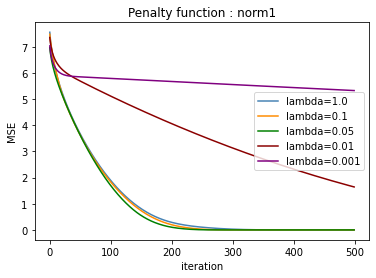

penalty_func: norm2
MSE: {1.0: 4.92775161831174e-07, 0.1: 1.2695020418659738e-08, 0.05: 6.682750079913245e-09, 0.01: 2.759944289566673, 0.001: 5.6579125787437565}


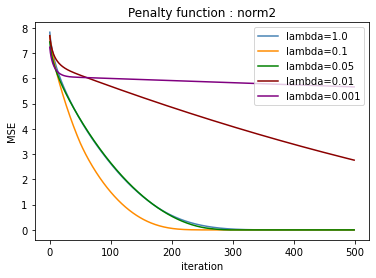

penalty_func: mocha
MSE: {1.0: 0.0012215305017091182, 0.1: 0.00814123292875352, 0.05: 0.10891135044252273, 0.01: 2.5131538119279773, 0.001: 5.954278546330874}


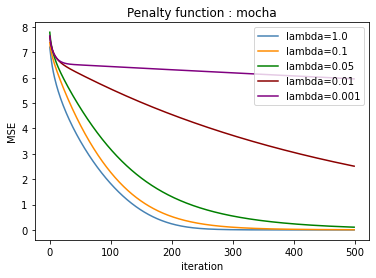

In [20]:
POUT = 0.001
lambda_lassos = [1.0, 0.1, 0.05, 0.01, 0.001]
colors = ['steelblue', 'darkorange', 'green', 'darkred', 'purple']
x1 = [i for i in range(K)]
for penalty_func in PENALTY_FUNCS:
    
    plt.close()
    MSEs = {}
    for i, lambda_lasso in enumerate(lambda_lassos):
        B, weight_vec, true_labels, datapoints = get_sbm_2blocks_data(pin=0.5, pout=POUT)
        
        samplingset = random.sample([i for i in range(N)], k=int(M * N))
                
        iteration_scores, predicted_w = algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func, calculate_score=True)
        
        alg1_score = get_score(datapoints, predicted_w, true_labels)
        MSEs[lambda_lasso] = alg1_score
        
        plt.plot(x1, iteration_scores, label='lambda='+str(lambda_lasso), c=colors[i])
    
    print('penalty_func:', penalty_func)
    print('MSE:', MSEs)
    
    plt.xlabel('iteration')
    plt.ylabel('MSE')
    plt.title('Penalty function : %s' % penalty_func)
    plt.legend(loc='best')
    plt.show()



penalty_func: norm1
MSE: {0.2: 8.89351555065316e-05, 0.4: 8.098248292499353e-07, 0.6: 1.1380283260083147e-08, 0.8: 5.2830674410165274e-09, 1.0: 2.6912206264740643e-09}


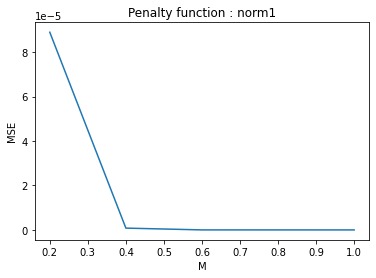

penalty_func: norm2
MSE: {0.2: 0.0002583771529449093, 0.4: 1.9643044152557672e-07, 0.6: 7.567213670373676e-09, 0.8: 1.164547311268322e-08, 1.0: 2.773597550294463e-09}


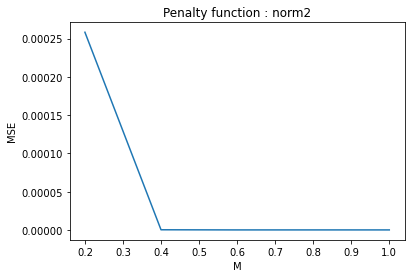

penalty_func: mocha
MSE: {0.2: 0.00316241577166385, 0.4: 0.00031286609024362146, 0.6: 0.00041527353084199245, 0.8: 0.00042588664786242435, 1.0: 8.003875601850601e-05}


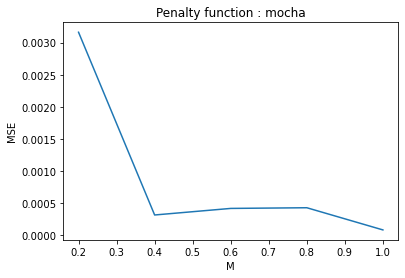

In [22]:
POUT = 0.001
lambda_lassos = {'norm1': 0.1, 'norm2': 0.1, 'mocha': 1.0}
sampling_ratios = [0.2, 0.4, 0.6, 0.8, 1.0]
colors = ['steelblue', 'darkorange', 'green', 'darkred', 'purple']
for penalty_func in PENALTY_FUNCS:
    
    MSEs = {}
    for i, sampling_ratio in enumerate(sampling_ratios):
        B, weight_vec, true_labels, datapoints = get_sbm_2blocks_data(pin=0.5, pout=POUT)
        
        samplingset = random.sample([i for i in range(N)], k=int(sampling_ratio * N))
                
        lambda_lasso = lambda_lassos[penalty_func]
        _, predicted_w = algorithm_1(300, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func)
        
        alg1_score = get_score(datapoints, predicted_w, true_labels)
        MSEs[sampling_ratio] = alg1_score
        
    
    print('penalty_func:', penalty_func)
    print('MSE:', MSEs)
    
    plt.close()
    plt.plot(list(MSEs.keys()), list(MSEs.values()))
    plt.xlabel('M')
    plt.ylabel('MSE')
    plt.title('Penalty function : %s' % penalty_func)
    plt.show()



penalty_func: norm1
MSE: {0.0: 1.3182603157802053e-08, 0.001: 8.20068174239206e-10, 0.01: 1.6772382646057271e-07, 0.1: 4.096296954393817, 0.2: 4.976453736983333, 0.4: 4.01212585803866, 0.6: 4.4203094119522275}


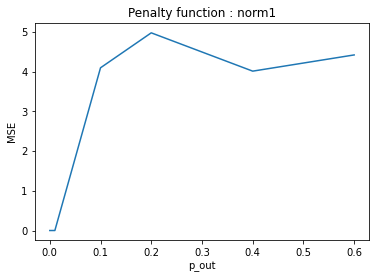

penalty_func: norm2
MSE: {0.0: 2.5856443589367032e-08, 0.001: 6.596284867564584e-09, 0.01: 7.67015171661296e-08, 0.1: 3.721846997705345, 0.2: 4.92230722413486, 0.4: 5.96249811656695, 0.6: 4.06845473183037}


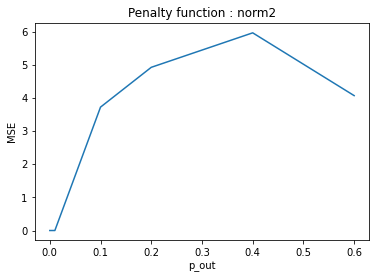

penalty_func: mocha
MSE: {0.0: 2.3223187486324142e-05, 0.001: 0.0014595302719249271, 0.01: 2.5237389004840494, 0.1: 5.0886372785647085, 0.2: 3.562265449822874, 0.4: 4.0823507564545265, 0.6: 6.02505250253493}


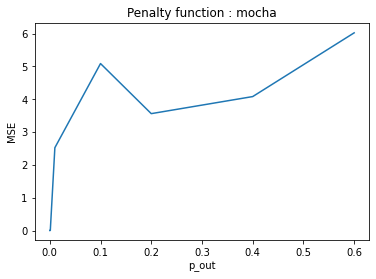

In [23]:
lambda_lassos = {'norm1': 0.1, 'norm2': 0.1, 'mocha': 1.0}
pouts = [0.0, 0.001, 0.01, 0.1, 0.2, 0.4, 0.6]

for penalty_func in PENALTY_FUNCS:
    MSEs = {}
    
    for pout in pouts:
        B, weight_vec, true_labels, datapoints = get_sbm_2blocks_data(pin=0.5, pout=pout)
        
        samplingset = random.sample([i for i in range(N)], k=int(M * N))
                
        lambda_lasso = lambda_lassos[penalty_func]
        _, predicted_w = algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func)
        
        alg1_score = get_score(datapoints, predicted_w, true_labels)
        MSEs[pout] = alg1_score
        
    print('penalty_func:', penalty_func)
    print('MSE:', MSEs)
    
    plt.close()
    plt.plot(list(MSEs.keys()), list(MSEs.values()))
    plt.xlabel('p_out')
    plt.ylabel('MSE')
    plt.title('Penalty function : %s' % penalty_func)
    plt.show()

    

penalty_func: norm1 pout: 0.0
noise MSE: {0: 1.4178859367823341e-08, 0.01: 9.505896873029422e-05, 0.1: 0.009111485494220953}
penalty_func: norm1 pout: 0.001
noise MSE: {0: 4.3078900246935826e-08, 0.01: 8.319461811038074e-05, 0.1: 0.01137399524769252}
penalty_func: norm1 pout: 0.1
noise MSE: {0: 4.331300872864871, 0.01: 4.052339321458038, 0.1: 4.376707755344356}
penalty_func: norm1 pout: 0.2
noise MSE: {0: 4.420807548171662, 0.01: 3.9681697450624727, 0.1: 3.886810065986162}
penalty_func: norm1 pout: 0.6
noise MSE: {0: 5.606866326530658, 0.01: 4.759506436648439, 0.1: 6.03700550381998}


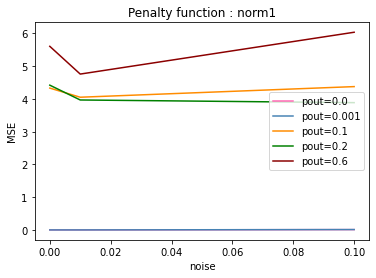

penalty_func: norm2 pout: 0.0
noise MSE: {0: 1.6004886697957799e-06, 0.01: 9.493637682846585e-05, 0.1: 0.009195034163104392}
penalty_func: norm2 pout: 0.001
noise MSE: {0: 2.4589256787924543e-07, 0.01: 0.00012022645183691002, 0.1: 0.009379333047458221}
penalty_func: norm2 pout: 0.1
noise MSE: {0: 4.13855035215799, 0.01: 5.507802257597087, 0.1: 4.253356934916724}
penalty_func: norm2 pout: 0.2
noise MSE: {0: 4.279990802063883, 0.01: 3.954846754827989, 0.1: 4.457957607956468}
penalty_func: norm2 pout: 0.6
noise MSE: {0: 4.212640373448071, 0.01: 4.3148466723198835, 0.1: 4.859208782035939}


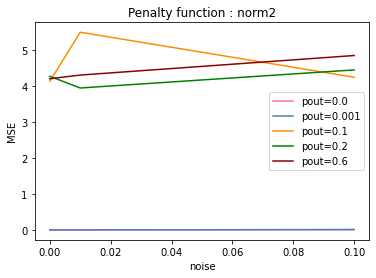

penalty_func: mocha pout: 0.0
noise MSE: {0: 2.175470727122179e-05, 0.01: 0.00013655059492942152, 0.1: 0.009390270968214758}
penalty_func: mocha pout: 0.001
noise MSE: {0: 0.0003737766702134008, 0.01: 0.0006342360279913348, 0.1: 0.01198289523302159}
penalty_func: mocha pout: 0.1
noise MSE: {0: 3.9319582245333295, 0.01: 5.7882088655302955, 0.1: 3.968006368369122}
penalty_func: mocha pout: 0.2
noise MSE: {0: 4.4059693972122655, 0.01: 4.372661105309913, 0.1: 4.137383504527408}
penalty_func: mocha pout: 0.6
noise MSE: {0: 4.317895792626453, 0.01: 4.540258874436274, 0.1: 4.978503036969184}


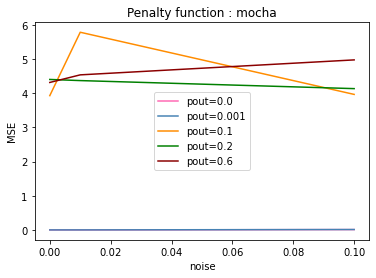

In [17]:
lambda_lassos = {'norm1': 0.1, 'norm2': 0.1, 'mocha': 1.0}
colors = ['hotpink', 'steelblue', 'darkorange', 'green', 'darkred', 'purple', 'dimgrey']
pouts = [0.0, 0.001, 0.1, 0.2, 0.6]
noises = [0, 0.01, 0.1]

for penalty_func in PENALTY_FUNCS:
    
    for i, pout in enumerate(pouts):
        
        MSEs = {}
        for noise in noises:
            B, weight_vec, true_labels, datapoints = get_sbm_2blocks_data(pin=0.5, pout=pout, noise_sd=noise)

            samplingset = random.sample([i for i in range(N)], k=int(M * N))

            lambda_lasso = lambda_lassos[penalty_func]
            _, predicted_w = algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func)

            alg1_score = get_score(datapoints, predicted_w, true_labels)
            MSEs[noise] = alg1_score

        plt.plot(list(MSEs.keys()), list(MSEs.values()), label='pout='+str(pout), c=colors[i])
        print('penalty_func:', penalty_func, 'pout:', pout)
        print('noise MSE:', MSEs)
        
    plt.xlabel('noise')
    plt.ylabel('MSE')
    plt.title('Penalty function : %s' % penalty_func)
    plt.legend(loc='best')
    plt.show()
    plt.close()

